In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import datetime
from xgboost import XGBRegressor
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.models import ExponentialSmoothing

from final_functions import draw_correlation


In [15]:

symbol = "GC=F"
ticker = yf.Ticker(symbol)
data = ticker.history(period="max")
data.reset_index(inplace=True)
data["Date"] = pd.to_datetime(data["Date"]).dt.date
df = data[["Date", "Close", "Volume"]]
df.rename(columns={"Close":symbol+"_Close", "Volume":symbol+"_Volume"}, inplace=True)
df

indices = ["^GSPC", "^DJI", "^IXIC", "^N225", "^FTSE", "^GDAXI", "^FCHI", "^HSI", "^BVSP", 'CL=F', 'SI=F', 'PL=F', 'EURUSD=X']


# Descargar los datos históricos de cada índice y agregarlos al DataFrame
for symbol in indices:
    ticker = yf.Ticker(symbol)
    data = ticker.history(period="max")
    data.reset_index(inplace=True)
    data["Date"] = pd.to_datetime(data["Date"]).dt.date # Convertir a objeto date
    data = data[["Date", "Close", "Volume"]]
    data.rename(columns={"Date":"Date", "Close":symbol+"_Close", "Volume":symbol+"_Volume"}, inplace=True)
    df = pd.merge(df, data, on="Date", how="left")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9800\114050021.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Close":symbol+"_Close", "Volume":symbol+"_Volume"}, inplace=True)


In [16]:
#Sabiendo el econding, podemos abrir el archivo y crear un df:
inflacion = pd.read_excel(r"C:\Users\LENOVO\Desktop\IronHack\Proyecto Final\inflacion.xlsx")

In [17]:
inflacion["Date"] = pd.to_datetime(inflacion["TIME"] + "-01")
inflacion = inflacion.set_index('Date').resample('D').interpolate().reset_index()
inflacion.drop("TIME", axis=1, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])

Final_DF = pd.merge(df, inflacion, on="Date", how="left")

In [18]:
Final_DF.fillna(method = "ffill", inplace=True)
Final_DF.dropna(inplace=True)
Final_DF.rename(columns={"Value":"Inflacion"}, inplace=True)

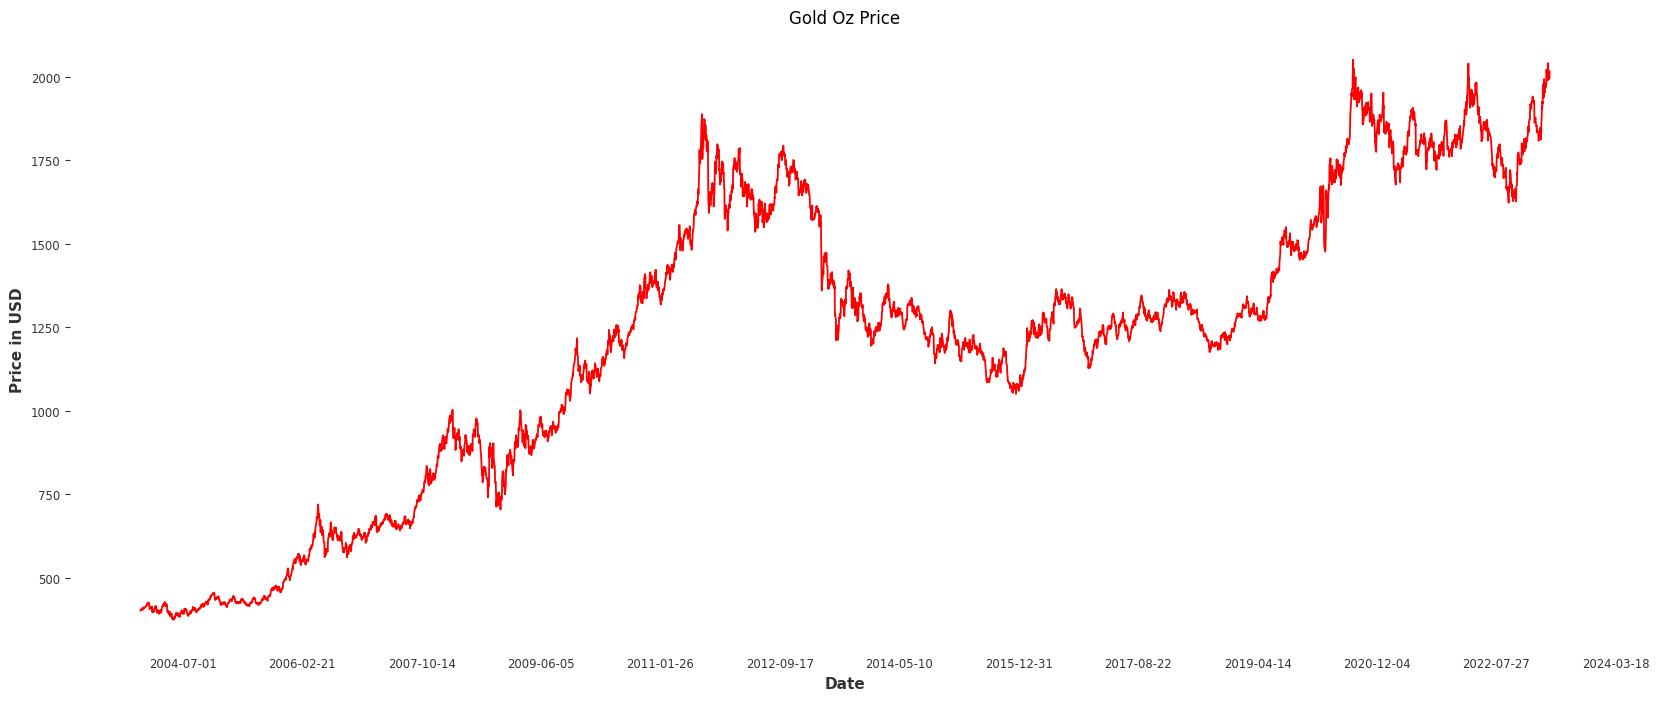

In [19]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(Final_DF['Date'], Final_DF['GC=F_Close'], color='Red')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.set_xlabel('Date', fontsize='11')
ax.set_ylabel('Price in USD', fontsize='11')
plt.title('Gold Oz Price')
plt.grid()
plt.show()

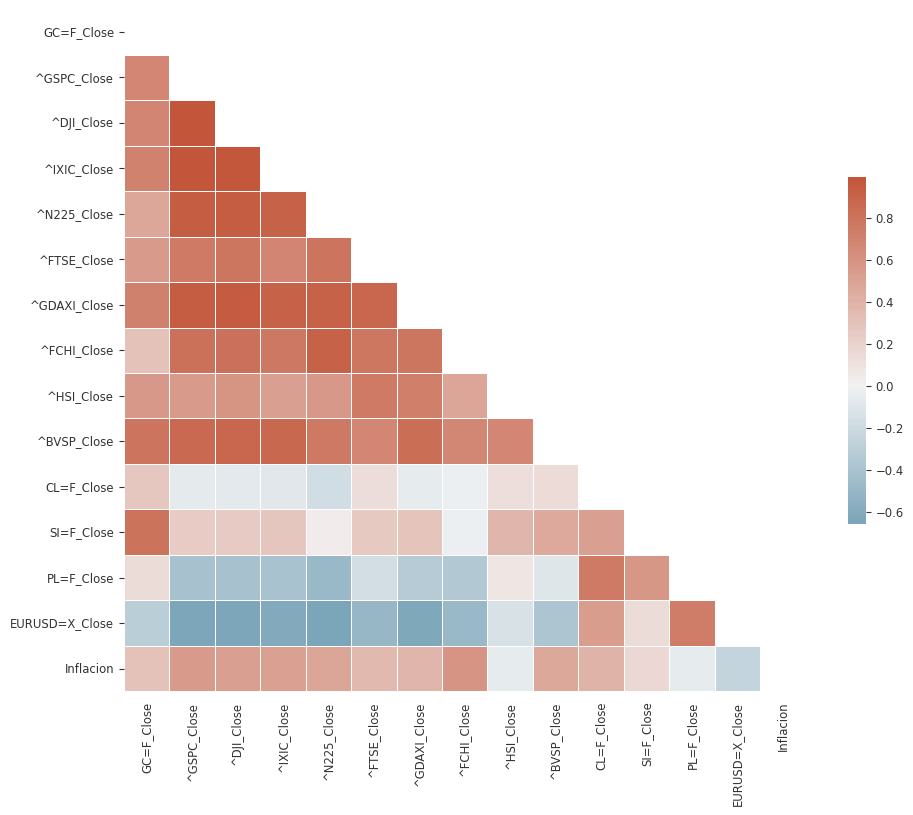

In [20]:
draw_correlation(Final_DF[["GC=F_Close", '^GSPC_Close', '^DJI_Close', '^IXIC_Close', '^N225_Close', '^FTSE_Close', '^GDAXI_Close', '^FCHI_Close', '^HSI_Close', '^BVSP_Close', 'CL=F_Close', 'SI=F_Close', 'PL=F_Close', 'EURUSD=X_Close', "Inflacion"]].corr())

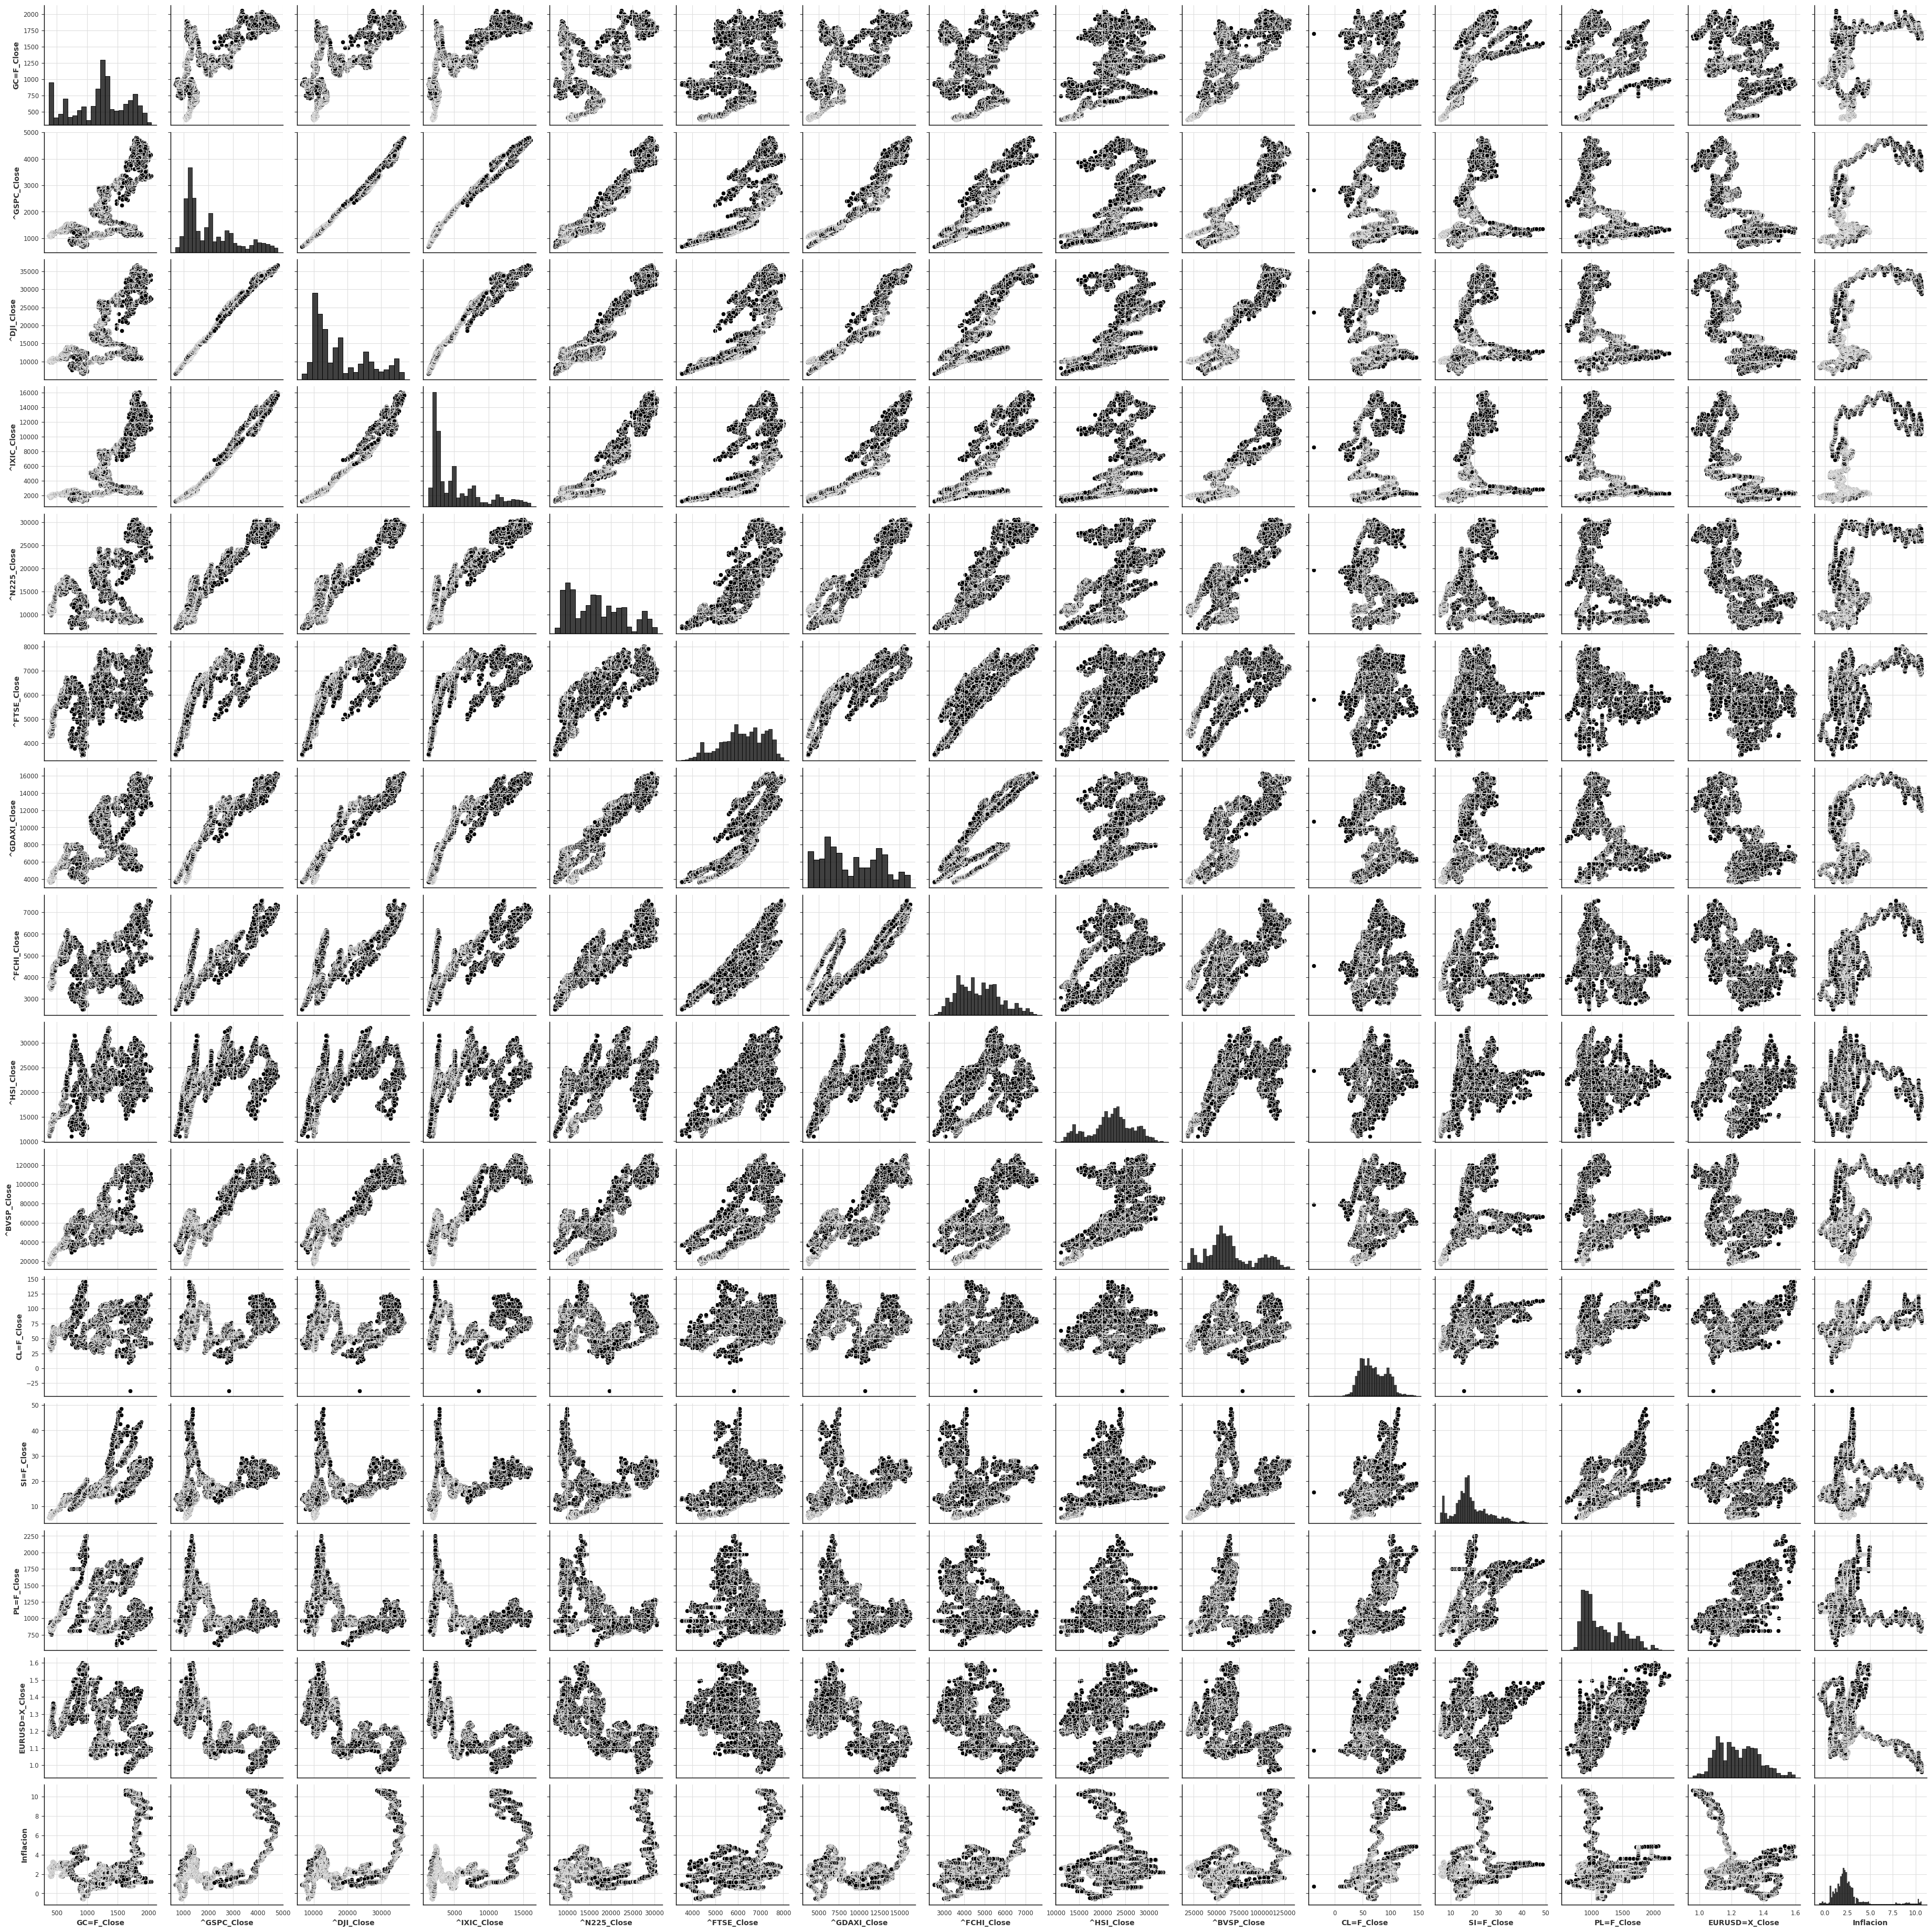

In [21]:
sns.pairplot(Final_DF[["GC=F_Close", '^GSPC_Close', '^DJI_Close', '^IXIC_Close', '^N225_Close', '^FTSE_Close', '^GDAXI_Close', '^FCHI_Close', '^HSI_Close', '^BVSP_Close', 'CL=F_Close', 'SI=F_Close', 'PL=F_Close', 'EURUSD=X_Close', "Inflacion"]])

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9800\1550995587.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X.corrwith(Final_DF['GC=F_Close']).plot.bar(


<AxesSubplot: title={'center': 'Correlation with Gold Adj Close'}>

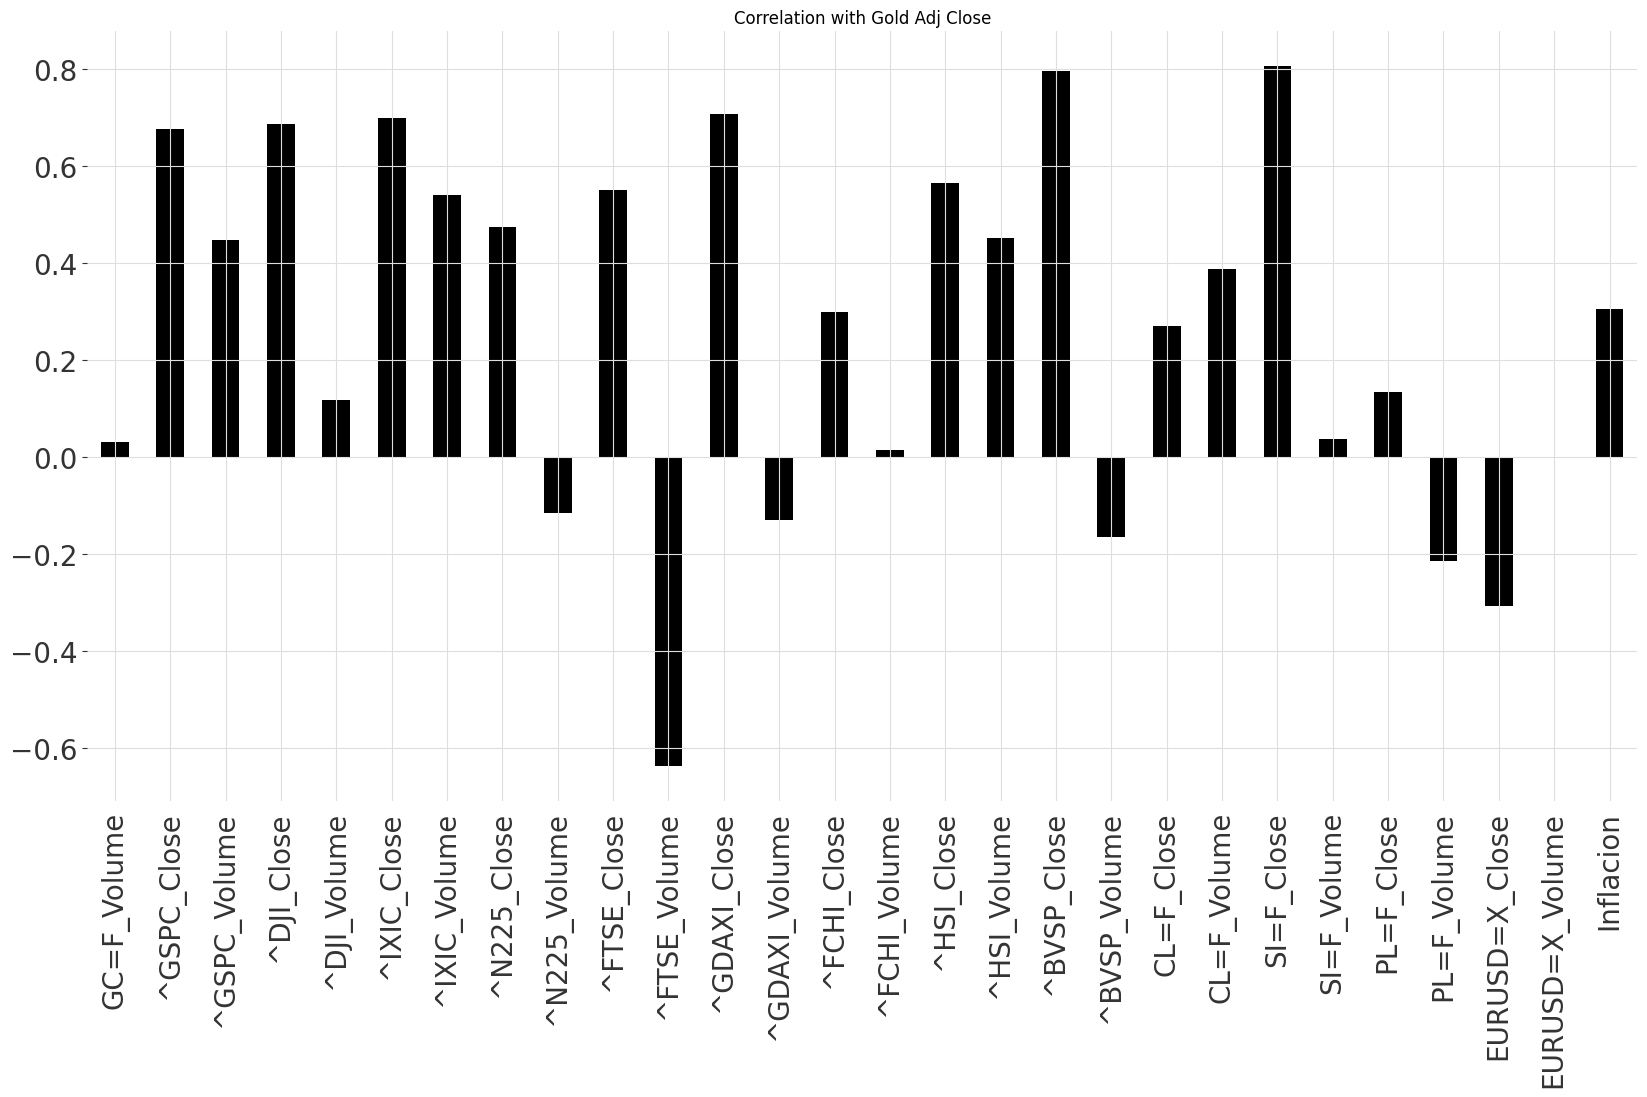

In [22]:
X=Final_DF.drop(['GC=F_Close'],axis=1)
X.corrwith(Final_DF['GC=F_Close']).plot.bar(
        figsize = (20, 10), title = "Correlation with Gold Adj Close", fontsize = 20,
        rot = 90, grid = True)

In [23]:
Final_DF = Final_DF[["Date", 'GC=F_Close', '^GSPC_Close',
       '^GSPC_Volume', '^DJI_Close',
       '^IXIC_Close',
       '^IXIC_Volume', '^N225_Close',
       '^FTSE_Close',
       '^FTSE_Volume', '^GDAXI_Close', 
       '^FCHI_Close', 
       '^HSI_Close', 
       '^HSI_Volume', '^BVSP_Close', 
       'CL=F_Close', 
       'CL=F_Volume', 'SI=F_Close', 
       'PL=F_Close', 'PL=F_Volume',
       'EURUSD=X_Close', "Inflacion"]]

In [24]:
Final_DF = Final_DF.round(2)
Final_DF = Final_DF.replace(0.00, np.nan)

In [25]:
Final_DF.fillna(method = "ffill", inplace=True)
Final_DF.fillna(method = "bfill", inplace=True)

In [26]:
x = Final_DF[['^GSPC_Close',
       '^GSPC_Volume', '^DJI_Close',
       '^IXIC_Close',
       '^IXIC_Volume', '^N225_Close',
       '^FTSE_Close',
       '^FTSE_Volume', '^GDAXI_Close', 
       '^FCHI_Close', 
       '^HSI_Close', 
       '^HSI_Volume', '^BVSP_Close', 
       'CL=F_Close', 
       'CL=F_Volume', 'SI=F_Close', 
       'PL=F_Close', 'PL=F_Volume',
       'EURUSD=X_Close', "Inflacion"]]
y = Final_DF[['GC=F_Close']]

In [27]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

Valores_New = pd.DataFrame()

columns_to_forecast = Final_DF[['^GSPC_Volume', '^DJI_Close',
       '^IXIC_Close',
       '^IXIC_Volume', '^N225_Close',
       '^FTSE_Close',
       '^FTSE_Volume', '^GDAXI_Close', 
       '^FCHI_Close', 
       '^HSI_Close', 
       '^HSI_Volume', '^BVSP_Close', 
       'CL=F_Close', 
       'CL=F_Volume', 'SI=F_Close', 
       'PL=F_Close', 'PL=F_Volume',
       'EURUSD=X_Close', 'Inflacion']]

# Initialize an empty DataFrame to store the forecasted values
Valores_New = pd.DataFrame()

# Loop through each column and forecast the next day's value
for col in columns_to_forecast:
    # Build and train the Simple Exponential Smoothing model
    model = SimpleExpSmoothing(x[col])
    model_fit = model.fit()

    # Make a one-step ahead forecast
    forecast = model_fit.forecast(steps=1)

    # Append the forecasted value as a new row at the end of the DataFrame
    Valores_New[col] = forecast

# Get the forecasted values for the next day
forecast_values = Valores_New.iloc[0].values



c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310

In [28]:
x = Final_DF[['^GSPC_Volume', '^DJI_Close',
       '^IXIC_Close',
       '^IXIC_Volume', '^N225_Close',
       '^FTSE_Close',
       '^FTSE_Volume', '^GDAXI_Close', 
       '^FCHI_Close', 
       '^HSI_Close', 
       '^HSI_Volume', '^BVSP_Close', 
       'CL=F_Close', 
       'CL=F_Volume', 'SI=F_Close', 
       'PL=F_Close', 'PL=F_Volume',
       'EURUSD=X_Close', "Inflacion"]]
y = Final_DF[['GC=F_Close']]

In [29]:

# Dividir el DataFrame en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define los mejores hiperparámetros encontrados
colsample_bytree = 1.0 
learning_rate = 0.07
max_depth =  9
min_child_weight =  1.1
n_estimators = 800
subsample = 0.7

# Initialize the XGBoost model with the specified hyperparameters
model = XGBRegressor(
    learning_rate=learning_rate,
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    n_estimators=n_estimators,
    random_state=42
)

# Train the model with the training data
model.fit(x_train, y_train)


In [ ]:

# Use the model to make predictions on the forecasted values
y_pred = model.predict(Valores_New)
# Get the forecasted price for tomorrow
forecasted_price = y_pred[0]
print(f"Forecasted price for tomorrow: {forecasted_price}")

Forecasted price for tomorrow: 2027.677001953125
